# Null Model Validation (H1 extension)


Statistical Validation of H1

In Notebook 02, we found that Thames crossings carry **8.6% of CRREB mass on 3.2% of edges**, a 2.7× over-representation. But is this statistically significant, or could it occur by chance?

**Question:** If we randomly selected 15 edges with the *same length distribution* as actual crossings, would they carry similar CRREB mass?

**Method:** Matched random-set null model with 1,000 iterations.


In [ ]:
from __future__ import annotations

import logging
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.core.config import SEED, configure_logging, get_paths

In [ ]:
LOGGER = logging.getLogger("null_model_validation")

In [ ]:
configure_logging()
paths = get_paths()

out_dir = paths.data_analysis / "04_null_model_and_legacy_equity"
out_dir.mkdir(parents=True, exist_ok=True)

In [5]:
n_null = 1000
q_bins = 5
seed = int(SEED)
exclude_zone1 = False

### **Null model (CRREB concentration)** 

### The Problem with Simple Comparisons

In Notebook 02, it was noted that crossings carry 2.7× their proportional share of CRREB mass. But this could be explained by a confound:

> **Crossings are long edges** (they span the river). Long edges might naturally carry more CRREB simply because they cover more distance. If we compared crossings to *random* edges, we'd be comparing long edges to short edges.

### The Solution: Matched Random-Set Null Model

I construct a null distribution by:

1. **Bin all edges by length** (5 distance quintiles)
2. **Count how many crossings fall in each bin**
3. **For each null iteration:**
   - Sample the same number of *non-crossing* edges from each bin
   - Sum their CRREB values
4. **Compare observed crossing CRREB to null distribution**

This answers: **"Is crossing CRREB concentration higher than expected for edges of similar length?"**

### Other Considered Approaches

| Alternative Design | Problem | Our Solution |
|--------------------|---------|--------------|
| Simple label permutation | Permutes crossing labels to edges with different lengths → "impossible worlds" | Match on length bins |
| Random edge sampling | Doesn't control for length confound | Stratified sampling by distance quintile |
| Parametric test | Assumes distribution shape | Non-parametric (empirical p-value) |

### Test Statistic

$$S = \sum_{e \in \text{selected edges}} \text{CRREB}(e)$$

- **Observed**: $S_{\text{obs}}$ = sum of CRREB on the 15 actual crossings
- **Null**: $S_{\text{null}}^{(i)}$ = sum of CRREB on 15 distance-matched non-crossings (iteration $i$)

### P-Value Calculation

$$p = \frac{\#\{S_{\text{null}}^{(i)} \geq S_{\text{obs}}\} + 1}{N + 1}$$

In [6]:
crreb = pd.read_csv(paths.processed_metrics / "crreb_edges.csv", dtype={"u": "string", "v": "string"})

In [7]:
crossing_mask = crreb["is_thames_crossing"].fillna(False)

In [8]:
crreb = (
    crreb.assign(
        _is_crossing=crossing_mask.astype(bool).values,
        crreb=lambda df: pd.to_numeric(df["crreb"], errors="coerce"),
        distance_m=lambda df: pd.to_numeric(df["distance_m"], errors="coerce"),
    )
    .dropna(subset=["crreb", "distance_m"])
    .reset_index(drop=False)
    .rename(columns={"index": "_row_index"})
    .assign(
        _bin=lambda df: pd.qcut(
            df["distance_m"], q=q_bins, labels=False, duplicates="drop"
        ).astype("Int64")
    )
    .dropna(subset=["_bin"])
    .assign(_bin=lambda df: df["_bin"].astype(int))
)

In [9]:
crossings = crreb[crreb["_is_crossing"]]
noncross = crreb[~crreb["_is_crossing"]]
n_cross = int(crossings.shape[0])

In [10]:
n_cross

15

In [11]:
req = crossings["_bin"].value_counts().to_dict()
bins = sorted(set(crreb["_bin"].tolist()))
n_bins = len(bins)

In [12]:
n_bins

5

In [13]:
rng = np.random.default_rng(seed)
used_replacement = False

s_null = np.zeros(n_null, dtype=float)
sampled_rows = []

# Precompute noncross indices by bin for speed
pool_by_bin = {}
for b in bins:
    pool = noncross.loc[noncross["_bin"] == b, "_row_index"].to_numpy()
    pool_by_bin[b] = pool

In [14]:
crreb

,_row_index,u,v,crreb,distance_m,line_ids,modes,is_thames_crossing,_is_crossing,_bin
0,0,1000002,1000048,43.500000,1290.600047,district,tube,False,False,2
1,1,1000002,1000063,1154.983333,958.119398,district;piccadilly,tube,False,False,1
2,2,1000002,1000208,694.750000,1881.111402,piccadilly,tube,False,False,4
3,3,1000002,1000240,720.233333,1996.558081,piccadilly,tube,False,False,4
4,4,1000048,1000240,17.500000,923.886792,district,tube,False,False,1
...,...,...,...,...,...,...,...,...,...,...
462,462,1002025,1002074,2114.000000,494.636299,dlr,dlr,False,False,0
463,463,1002048,1002061,1731.000000,463.965258,dlr,dlr,False,False,0
464,464,1002046,1002074,2446.000000,520.729644,dlr,dlr,False,False,0
465,465,1002046,1003008,2493.000000,181.001889,dlr,dlr,False,False,0


In [15]:
crreb_index_1d = crreb["_row_index"]
crreb_crreb_1d = crreb["crreb"]

values_by_row = dict(zip(crreb_index_1d.tolist(), crreb_crreb_1d.tolist()))

for it in range(n_null):
    picked = []
    for b, k in req.items():
        pool = pool_by_bin.get(int(b), np.array([], dtype=int))
        if pool.size == 0:
            used_replacement = True
            continue
        if pool.size < int(k):
            used_replacement = True
            choice = rng.choice(pool, size=int(k), replace=True)
        else:
            choice = rng.choice(pool, size=int(k), replace=False)
        picked.extend([int(x) for x in choice.tolist()])
    # If, due to empty bins, we sampled fewer than n_cross, top up from all noncross
    if len(picked) < n_cross:
        used_replacement = True
        remaining = n_cross - len(picked)
        all_pool = noncross["_row_index"].to_numpy()
        top = rng.choice(all_pool, size=int(remaining), replace=True)
        picked.extend([int(x) for x in top.tolist()])

    # Compute statistic
    s = 0.0
    for ridx in picked:
        v = values_by_row.get(ridx)
        if v is not None and np.isfinite(float(v)):
            s += float(v)
    s_null[it] = s
    sampled_rows.append({"iter": it, "sampled_row_indices": ",".join(map(str, picked))})

s_obs = float(crossings["crreb"].sum())
p_val = float((np.sum(s_null >= s_obs) + 1) / (n_null + 1))

1,000 iterations of matched random sampling completed. Each iteration:
1. Sampled 15 non-crossing edges matching the crossing length distribution
2. Summed their CRREB values
3. Stored the sum as one null observation

I now compare the observed crossing CRREB to this null distribution.

In [16]:
s_obs, p_val

(23476.078047391195, 0.000999000999000999)

In [17]:
samples_df = pd.DataFrame(sampled_rows)

In [18]:
samples_df.head()

,iter,sampled_row_indices
0,0,"367,71,288,18,255,299,16,415,332,453,63,267,46..."
1,1,"201,367,432,314,374,255,246,349,274,341,332,46..."
2,2,"275,314,264,2,308,336,252,34,332,24,206,441,27..."
3,3,"179,275,384,199,117,212,301,326,295,61,335,221..."
4,4,"275,62,430,28,349,107,304,313,41,243,57,157,28..."


**Null model Summary**

In [19]:
print(
    f"n_null: {n_null}\n"
    f"n_obs crossings: {n_cross}\n"
    f"s_obs: {s_obs:.3f}\n"
    f"s_null mean: {np.mean(s_null):.3f}\n"
    f"s_null std: {np.std(s_null):.3f}\n"
    f"empirical p-value: {p_val:.5f}\n"
)


n_null: 1000
n_obs crossings: 15
s_obs: 23476.078
s_null mean: 8532.552
s_null std: 3200.913
empirical p-value: 0.00100



### Null Model Results

| Statistic | Value |
|-----------|-------|
| **Observed CRREB (crossings)** | 23,476 |
| **Null mean** | 8,533 |
| **Null std** | 3,201 |
| **Standardized gap** | (23,476 - 8,533) / 3,201 = **4.7σ** |
| **Empirical p-value** | **0.001** (floor at 1/1001) |

### Interpretation

The observed CRREB concentration on crossings is **4.7 standard deviations above** what we'd expect from length-matched random edges. The empirical p-value of 0.001 is at the floor (no null samples exceeded observed), indicating:

> **p < 0.001**: The CRREB concentration on Thames crossings is highly statistically significant, even after controlling for edge length.

This validates the H1 finding from Notebook 02: crossings don't just carry high CRREB because they're long edges. They carry high CRREB because they're **crossings**.

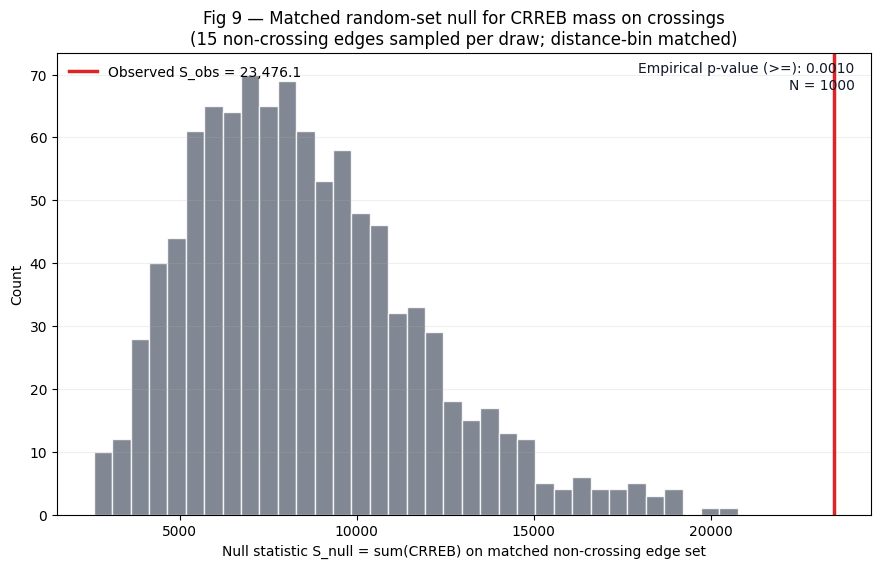

In [20]:
fig, ax = plt.subplots(figsize=(10.5, 6.0))
ax.hist(s_null, bins=35, color="#6b7280", alpha=0.85, edgecolor="white")
ax.axvline(s_obs, color="#dc2626", lw=2.5, label=f"Observed S_obs = {s_obs:,.1f}")
ax.set_title(
    "Fig 9 — Matched random-set null for CRREB mass on crossings\n"
    "(15 non-crossing edges sampled per draw; distance-bin matched)"
)
ax.set_xlabel("Null statistic S_null = sum(CRREB) on matched non-crossing edge set")
ax.set_ylabel("Count")
ax.grid(axis="y", alpha=0.2)

txt = f"Empirical p-value (>=): {p_val:.4f}\nN = {len(s_null)}"
ax.text(
    0.98,
    0.98,
    txt,
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=10,
    color="#111827",
)

ax.legend(loc="upper left", frameon=False)
plt.show()

This histogram shows:
- **Gray bars**: Distribution of CRREB sums from 1,000 matched random edge sets
- **Red line**: Observed CRREB sum on actual crossings (23,476)

**Key observation:** The observed value is far to the right of the entire null distribution. No null sample approached the observed value, hence p < 0.001.